## Sequence Variational Encoder 

In this notebook we implement a encoder similar to the one explained in the paper
https://arxiv.org/abs/1803.05428

In [1]:
import torch
import torch.nn as nn
from torch import nn, optim
from torch.nn import functional as F

# Libraries useful for the test dataset
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_input_sequences(input_data, tw):
    input_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        input_seq.append(train_seq)
    return input_seq

In [3]:
# Here we create a set sequences of data
flight_data = sns.load_dataset("flights")
all_data = flight_data['passengers'].values.astype(float)
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 12
train_input_seq = create_input_sequences(train_data_normalized, train_window)

In [4]:
# The input_size is the size of the sequence
# The latent_dim is the dimension of the latent space
class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super().__init__()
        self.input_size = input_size
        self.latent_dim = latent_dim        
        self.hidden_cell = (torch.zeros(2,1,self.input_size),
                            torch.zeros(2,1,self.input_size))
        
        self.lstm = nn.LSTM(input_size, input_size, bidirectional = True)
        self.h = nn.Linear(2*input_size, input_size)
        self.mu = nn.Linear(input_size, latent_dim)
        self.logvar = nn.Linear(input_size, latent_dim)
        
    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
          
    def forward(self, input_seq):
        lstm_out, hidden_cell = self.lstm(input_seq.view(-1 ,1, len(input_seq)), self.hidden_cell)
        hidden_seq = torch.cat((hidden_cell[0][0], hidden_cell[0][1]), 1)
        hidden_seq = F.relu(self.h(hidden_seq))
        mu = self.mu(hidden_seq)
        logvar = self.logvar(hidden_seq)
        return self.sample(mu, logvar), mu, logvar

In [5]:
# The input_size is the size of the sequence
# The latent_dim is the dimension of the latent space
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_size):
        super().__init__()
        self.latent_dim = latent_dim 
        self.output_size = output_size  
        
        self.h = nn.Linear(latent_dim, 2*latent_dim)
        self.l1 = nn.Linear(2*latent_dim, output_size)
        self.lstm = nn.LSTM(output_size, output_size)
        
    def forward(self, input_seq):
        input_seq = F.relu(self.h(input_seq))
        input_seq = self.l1(input_seq)
        
        input_seq = input_seq.view(len(input_seq), 1, -1)
        hidden = (input_seq, torch.zeros(1, 1, self.output_size))
        lstm_out, hidden_cell = self.lstm(torch.rand(1,1,self.output_size), hidden) 
        out = F.relu(lstm_out.view(1,self.output_size))
        return torch.sigmoid(out)

In [6]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_hat, x, mu, logvar, beta=1.):
    """
    Check https://arxiv.org/abs/1312.6114 appendix
    """
    likelihood = F.binary_cross_entropy(x_hat, x.view(-1, 12), reduction = 'sum')
    div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return likelihood + beta * div

In [7]:
encoder = Encoder(12,6)
decoder = Decoder(6,12)
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr = 1e-4)

In [8]:
losses = []
for i in range(100):
    for i in range(len(train_input_seq)):
        x = train_input_seq[i]
        optimizer.zero_grad()
        z, mu, logvar = encoder(x)
        x_hat = decoder(z)
        loss = loss_function(x_hat, x, mu, logvar)
        losses.append(loss.item())
        loss.backward(retain_graph = True)
        optimizer.step()

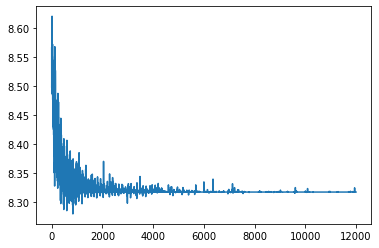

In [9]:
plt.plot(losses)

We have a fu**ing problem. The error goes down but just because the Autoencoder learns how to cheat.

We will fix it

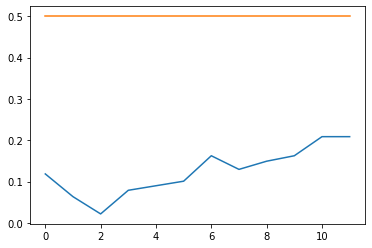

In [11]:
test = train_input_seq[20]
z, mu, logvar = encoder(test)
out = decoder(z)
plt.plot(test.detach().numpy())
plt.plot(out[0].detach().numpy())

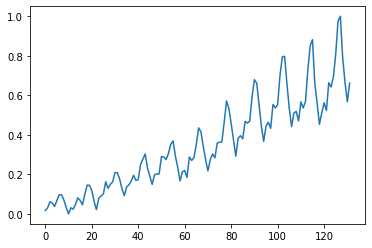

In [8]:
plt.plot(train_data_normalized)

## ------TEST------

In [224]:
encoder = Encoder(12,4)
input_seq = torch.rand(12,1)
out_seq = torch.rand(1,4) 
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(encoder.parameters(), lr = 0.001)

In [226]:
for i in range(10):
    optimizer.zero_grad()
    test = encoder(torch.rand(12,1))
    loss = loss_function(test[0], out_seq)
    loss.backward(retain_graph = True)
    optimizer.step()

In [92]:
latent_space_mapping = encoder(train_input_seq[0])
print(latent_space_mapping)
forecast_out = decoder(latent_space_mapping[0])

(tensor([[ 1.5969, -1.0974, -0.2379,  0.8868]], grad_fn=<AddBackward0>),
 tensor([[-0.1018,  0.1361,  0.0439,  0.0860]], grad_fn=<AddmmBackward>),
 tensor([[ 0.0249,  0.2832,  0.0918, -0.2946]], grad_fn=<AddmmBackward>))

In [185]:
latent_dim = 4
output_size = 12
l1 = nn.Linear(latent_dim, output_size)
lstm = nn.LSTM(output_size, output_size, bidirectional = True)

In [209]:
in_seq = torch.rand(1,1,output_size)
out_seq = torch.rand(1,2*output_size) 
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001)

In [221]:
losses = []
for i in range(1000):
    optimizer.zero_grad()
    test, hidden = lstm(in_seq)
    hid = torch.cat((hidden[0][0], hidden[0][1]), 1)
    loss = loss_function(hid, out_seq)
    losses.append(loss.item())
    loss.backward(retain_graph = True)
    optimizer.step()    

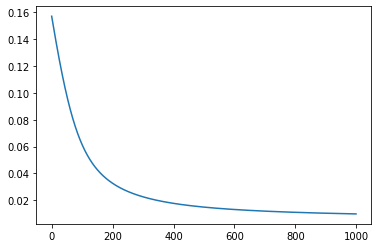

In [222]:
plt.plot(losses)